In [1]:
import pandas as pd
import numpy as np
import re

from sklearn.cluster import DBSCAN, KMeans
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import silhouette_score

# import kmeans1d
'''
kmeans1d

A Python library with an implementation of k-means clustering on 1D data, based on the algorithm in (Xiaolin 1991), as presented in section 2.2 of (Gronlund et al., 2017).

Globally optimal k-means clustering is NP-hard for multi-dimensional data. Lloyd's algorithm is a popular approach for finding a locally optimal solution. For 1-dimensional data, there are polynomial time algorithms. The algorithm implemented here is a O(kn + n log n) dynamic programming algorithm for finding the globally optimal k clusters for n 1D data points.

The code is written in C++, and wrapped with Python.
'''

# import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# shape (381109, 11)
# data_1 = pd.read_csv('datasets/d1.csv')
# data_1 = data_1.drop(['id'], axis=1)
data_1 = pd.read_csv('datasets/d1_bootstraped.csv')

data_2 = pd.read_csv('datasets/d2.csv')

In [3]:
data_1

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,Female,46,1,28.0,1,1-2 Year,No,2630.0,124.0,255,0
1,Male,60,1,28.0,0,1-2 Year,Yes,40770.0,26.0,77,0
2,Male,59,1,48.0,0,> 2 Years,Yes,2630.0,124.0,30,0
3,Female,24,1,33.0,1,< 1 Year,No,29419.0,152.0,82,0
4,Male,22,1,18.0,1,< 1 Year,No,26714.0,152.0,156,0
...,...,...,...,...,...,...,...,...,...,...,...
93415,Female,43,1,28.0,0,1-2 Year,Yes,42013.0,125.0,199,1
93416,Female,30,1,8.0,0,< 1 Year,Yes,41314.0,124.0,128,1
93417,Male,40,1,13.0,0,1-2 Year,Yes,34503.0,26.0,163,1
93418,Male,58,1,28.0,0,> 2 Years,Yes,51016.0,26.0,164,1


In [4]:
from itertools import combinations
columns_name = list(data_1.columns)
columns_name.remove('Response')
combX = []
comb_max_depth = 2
for idx, _ in enumerate(columns_name):
    if comb_max_depth and comb_max_depth == idx:
        break
    combX.extend(list(combinations(columns_name, idx + 1)))

combX = sorted(combX, key=len)
combX

[('Gender',),
 ('Age',),
 ('Driving_License',),
 ('Region_Code',),
 ('Previously_Insured',),
 ('Vehicle_Age',),
 ('Vehicle_Damage',),
 ('Annual_Premium',),
 ('Policy_Sales_Channel',),
 ('Vintage',),
 ('Gender', 'Age'),
 ('Gender', 'Driving_License'),
 ('Gender', 'Region_Code'),
 ('Gender', 'Previously_Insured'),
 ('Gender', 'Vehicle_Age'),
 ('Gender', 'Vehicle_Damage'),
 ('Gender', 'Annual_Premium'),
 ('Gender', 'Policy_Sales_Channel'),
 ('Gender', 'Vintage'),
 ('Age', 'Driving_License'),
 ('Age', 'Region_Code'),
 ('Age', 'Previously_Insured'),
 ('Age', 'Vehicle_Age'),
 ('Age', 'Vehicle_Damage'),
 ('Age', 'Annual_Premium'),
 ('Age', 'Policy_Sales_Channel'),
 ('Age', 'Vintage'),
 ('Driving_License', 'Region_Code'),
 ('Driving_License', 'Previously_Insured'),
 ('Driving_License', 'Vehicle_Age'),
 ('Driving_License', 'Vehicle_Damage'),
 ('Driving_License', 'Annual_Premium'),
 ('Driving_License', 'Policy_Sales_Channel'),
 ('Driving_License', 'Vintage'),
 ('Region_Code', 'Previously_Insured

In [5]:
data_1.nunique()

Gender                      2
Age                        66
Driving_License             2
Region_Code                53
Previously_Insured          2
Vehicle_Age                 3
Vehicle_Damage              2
Annual_Premium          32550
Policy_Sales_Channel      135
Vintage                   290
Response                    2
dtype: int64

1    57
0    43
Name: Response, dtype: int64

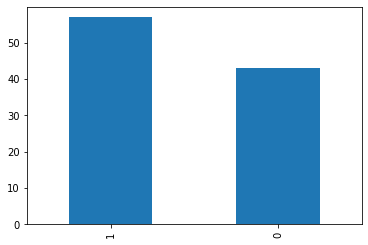

In [6]:
data_1 = data_1.sample(100)

data_1['Response'].value_counts().plot(kind='bar')
data_1['Response'].value_counts()

In [7]:
data_1.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
4484,Male,30,1,17.0,0,< 1 Year,Yes,41606.0,152.0,93,0
31905,Female,22,1,6.0,1,< 1 Year,No,26481.0,152.0,285,0
79722,Male,39,1,29.0,0,1-2 Year,Yes,2630.0,26.0,52,1
87230,Female,45,1,34.0,0,1-2 Year,Yes,40777.0,124.0,30,1
93236,Female,43,1,8.0,0,> 2 Years,Yes,36249.0,124.0,133,1


In [8]:
top_n = 10 
likely_dis = []

# check if attribute is continuous or discrete dataframe 
for var in data_1.columns:
    # Find the ratio of number of unique values to the total number of unique values. Something like the following
    # if 1.*data_1[var].nunique()/data_1[var].count() > 0.5:

    # Check if the top n unique values account for more than a certain proportion of all values
    if 1.*data_1[var].value_counts(normalize=True).head(top_n).sum() < 0.5:
        likely_dis.append(var)
        
likely_dis

['Age', 'Annual_Premium', 'Vintage']

In [53]:
# Scaleing is a process of transforming data into a stander values so we can get the best of it
# 
# https://stats.stackexchange.com/questions/89809/is-it-important-to-scale-data-before-clustering
scaler =  StandardScaler()
scaled_column_names = [x for x in likely_dis if x.lower() not in ['id']]
data_cluster = data_1[scaled_column_names].copy()
scaled_data = scaler.fit_transform(data_cluster)

data_scaled = data_1.copy()
data_scaled[scaled_column_names] = scaled_data
data_scaled

# [['Vintage','Annual_Premium']]
# scaler.inverse_transform([[0.748795	, 0.574539]])

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
4484,Male,-0.849981,1,17.0,0,< 1 Year,Yes,0.622206,152.0,-0.645932,0
31905,Female,-1.458196,1,6.0,1,< 1 Year,No,-0.337891,152.0,1.593081,0
79722,Male,-0.165739,1,29.0,0,1-2 Year,Yes,-1.851893,26.0,-1.124054,1
87230,Female,0.290423,1,34.0,0,1-2 Year,Yes,0.569583,124.0,-1.380608,1
93236,Female,0.138369,1,8.0,0,> 2 Years,Yes,0.282157,124.0,-0.179471,1
...,...,...,...,...,...,...,...,...,...,...,...
18491,Female,1.126719,1,8.0,0,1-2 Year,Yes,-1.851893,26.0,-1.089070,0
77396,Female,2.191096,1,28.0,0,> 2 Years,Yes,0.997485,24.0,-0.727563,1
5723,Male,1.430827,1,15.0,0,1-2 Year,Yes,0.272127,26.0,1.010005,0
89978,Male,-0.697927,1,28.0,0,1-2 Year,Yes,-1.851893,156.0,0.893389,1


In [10]:
from scipy import stats
data_scaled = data_scaled[(np.abs(stats.zscore(data_scaled.Annual_Premium)) < 3)]
data_scaled

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
4484,Male,-0.849981,1,17.0,0,< 1 Year,Yes,0.622206,152.0,-0.645932,0
31905,Female,-1.458196,1,6.0,1,< 1 Year,No,-0.337891,152.0,1.593081,0
79722,Male,-0.165739,1,29.0,0,1-2 Year,Yes,-1.851893,26.0,-1.124054,1
87230,Female,0.290423,1,34.0,0,1-2 Year,Yes,0.569583,124.0,-1.380608,1
93236,Female,0.138369,1,8.0,0,> 2 Years,Yes,0.282157,124.0,-0.179471,1
...,...,...,...,...,...,...,...,...,...,...,...
18491,Female,1.126719,1,8.0,0,1-2 Year,Yes,-1.851893,26.0,-1.089070,0
77396,Female,2.191096,1,28.0,0,> 2 Years,Yes,0.997485,24.0,-0.727563,1
5723,Male,1.430827,1,15.0,0,1-2 Year,Yes,0.272127,26.0,1.010005,0
89978,Male,-0.697927,1,28.0,0,1-2 Year,Yes,-1.851893,156.0,0.893389,1


In [ ]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

X = np.array(data_scaled.Annual_Premium.tolist()).reshape(-1,1)

for n_clusters in range(3,9):
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

In [ ]:
K = range(1,10)
for att in scaled_column_names:
    Sum_of_squared_distances = []
    for num_clusters in K :
        kmeans = KMeans(n_clusters=num_clusters)
        kmeans.fit(np.array(data_scaled[att].tolist()).reshape(-1, 1))
        Sum_of_squared_distances.append(kmeans.inertia_)
    print(Sum_of_squared_distances)
    plt.plot(K,Sum_of_squared_distances,"bx-")
    plt.xlabel("Values of K") 
    plt.ylabel("Sum of squared distances/Inertia") 
    plt.title("Elbow Method For Optimal k")
    plt.show()

In [ ]:
range_n_clusters = range(2,9)
silhouette_avg = []
for num_clusters in range_n_clusters:
    # initialize kmeans
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(np.array(scaled_data.tolist()).reshape(-1, 1))
    cluster_labels = kmeans.labels_

    # silhouette score
    silhouette_avg.append(silhouette_score(scaled_data.reshape(-1, 1), cluster_labels))

plt.plot(range_n_clusters, silhouette_avg, 'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.show()

In [ ]:
%%time


clustering = DBSCAN(eps=0.5, min_samples=4).fit(
# clustering = KMeans(n_clusters=4).fit(
        np.array(data_1['months_as_customer'].tolist()).reshape(-1, 1)
    )
clustering1 = DBSCAN(eps=0.5, min_samples=4).fit(
# clustering = KMeans(n_clusters=4).fit(
        np.array(data_1['total_claim_amount'].tolist()).reshape(-1, 1)
    )

p = pd.DataFrame(zip(clustering.labels_, clustering1.labels_), columns=['months_as_customer', 'total_claim_amount'])
p.nunique()

In [ ]:
data_after_clsuter = data_scaled.copy()
data_after_clsuter[scaled_column_names] = scaler.inverse_transform(scaled_data)
data_after_clsuter.head()

In [ ]:

data_cluster_sort = data_after_clsuter.copy()
data_cluster_sort['cluster'] = clustering.labels_
data_cluster_sort.sort_values(['cluster'], inplace=True)
data_cluster_sort.to_csv('data_cluster_sort.csv')
data_cluster_sort.head()

In [12]:
le = LabelEncoder()
encoder_dict = dict()
data_endocded = data_scaled.copy()

for col in data_endocded:
    if col not in ['Annual_Premium', 'Vintage']:
        le = le.fit(data_endocded[col])
        data_endocded[col] = le.transform(data_endocded[col])
        encoder_dict[col] = le

np.save('encoder_dict.npy', encoder_dict)
# encoder_dict = np.load('encoder_dict.npy', allow_pickle=True).tolist()
data_endocded.to_csv('data_endocded.csv', index=False)
data_endocded = pd.read_csv('data_endocded.csv')

In [13]:
data_endocded.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,9,0,11,0,1,1,0.622206,13,-0.645932,0
1,0,1,0,2,1,1,0,-0.337891,13,1.593081,0
2,1,17,0,16,0,0,1,-1.851893,6,-1.124054,1
3,0,22,0,20,0,0,1,0.569583,11,-1.380608,1
4,0,20,0,3,0,2,1,0.282157,11,-0.179471,1


In [129]:
class RST:
    def __init__(
        self,
        data: pd.DataFrame = None,
        continuous_columns: list = [],
        decision_column_name: str = 'class',
    ):

        
        # Primary variable of RST class
        self.data = data
        self.data_indiscernibility = {}
        self.unique_indiscernibility = []
        self.reduct_combination = []
        self.continuous_columns = continuous_columns
        self.decision_column_name = decision_column_name
        self.lower_approx = {}
        self.upper_approx = {}
        self.boundary_region = {}
        self.outside_region = {}
        self.U = self._list_to_set_conversion(self.data.index.values.tolist())

        # Config Variable
        self.target_unique = self.data[decision_column_name].unique()
        self.target_sets = self.get_indiscernibility([decision_column_name])[0]
        self.target_sets_dict = {self.target_unique[idx]: ele for idx, ele in enumerate(self.target_sets[decision_column_name])}

    def get_indiscernibility(self, combination: list = []):
        
        def indices(lst, item):
            return [i for i, x in enumerate(lst) if x == item]
            
        if self.decision_column_name not in combination:
            combination.append(self.decision_column_name)

        
        selected_columns = self.data[combination].to_dict('list')
        data = list(zip(*selected_columns.values()))

        # print(combination, list(indices(data, x) for x in set(data) if data.count(x) > 1))
        if list(indices(data, x) for x in set(data) if data.count(x) > 1) in self.unique_indiscernibility:
            self.reduct_combination.append(self._create_names(combination))
        else:
            self.unique_indiscernibility.append(list(indices(data, x) for x in set(data) if data.count(x) > 1))

            self.data_indiscernibility.update({
                self._create_names(combination): list(indices(data, x) for x in set(data) if data.count(x) > 1)
            })

        return [self.data_indiscernibility, self.reduct_combination]

    def set_main_variable(self, combination: list = []):
        combination.append(self.decision_column_name)
        _c_n = self._create_names(combination)  # combination name
        
        if _c_n not in self.data_indiscernibility:
            self.get_indiscernibility(combination)
        if _c_n in self.reduct_combination:
            return [{},{},{},{}]

        combination_upper = {}
        combination_lower = {}

        for target, set in self.target_sets_dict.items():
            c = combination.copy()
            c.append(str(target))
            __c_n = self._create_names(c)
            
            self.lower_approx.update({__c_n: []})
            self.upper_approx.update({__c_n: []})
            self.boundary_region.update({__c_n: []})
            self.outside_region.update({__c_n: []})

            for IND in self.data_indiscernibility[_c_n]:
                if all(True if x in set else False for x in IND):
                    self.lower_approx[__c_n].extend(IND)

                if any(True if x in set else False for x in IND):
                    self.upper_approx[__c_n].extend(IND)

            combination_lower.update({__c_n: self.lower_approx[__c_n]})
            combination_upper.update({__c_n: self.upper_approx[__c_n]})

            upper = self._list_to_set_conversion(self.upper_approx[__c_n])
            lower = self._list_to_set_conversion(self.lower_approx[__c_n])
            
            # print(upper, lower)
            self.boundary_region[__c_n].extend(upper - lower)
            self.outside_region[__c_n].extend(self.U - upper)
            # print(self.boundary_region)

        return [
            combination_upper,
            combination_lower,
            self.boundary_region[__c_n],
            self.outside_region[__c_n]
        ]

    def get_dependency(self, combination: list = []):
        _, lower, _, _ = self.set_main_variable(combination)
        divider = sum([len(v) for v in lower.values()])
        dependency = divider / len(self.U)
        return [
            lower,
            dependency
        ]

    def _create_names(self, e) -> str:
        return '|'.join(e)

    def _list_to_set_conversion(self, l):
        se = set()
        for x in l:
            se.add(x)
        return se


In [134]:
rst = RST(data_endocded, continuous_columns=likely_dis, decision_column_name='Response')
# upper, lower, boundary, outside = rst.set_main_variable(combination=['Gender', 'Age'])
dep = {}
ind = []
for comb in combX:
    lower, dependency = rst.get_dependency(combination=list(comb))
    dep.update({comb: dependency})
    # print(len(ind))
    
    # print(set(ind))
    # if indiscernibility in dep.keys():
    #     dep[indiscernibility].append(comb)
    # else:
    #     dep.update({indiscernibility: [comb]})
print(dep)
# dep

{('Gender',): 1.0, ('Age',): 0.63, ('Driving_License',): 1.0, ('Region_Code',): 0.79, ('Previously_Insured',): 1.0, ('Vehicle_Age',): 1.0, ('Vehicle_Damage',): 1.0, ('Annual_Premium',): 0.15, ('Policy_Sales_Channel',): 0.86, ('Vintage',): 0.27, ('Gender', 'Age'): 0.38, ('Gender', 'Driving_License'): 1.0, ('Gender', 'Region_Code'): 0.72, ('Gender', 'Previously_Insured'): 1.0, ('Gender', 'Vehicle_Age'): 1.0, ('Gender', 'Vehicle_Damage'): 1.0, ('Gender', 'Annual_Premium'): 0.15, ('Gender', 'Policy_Sales_Channel'): 0.79, ('Gender', 'Vintage'): 0.21, ('Age', 'Driving_License'): 0.63, ('Age', 'Region_Code'): 0.13, ('Age', 'Previously_Insured'): 0.58, ('Age', 'Vehicle_Age'): 0.54, ('Age', 'Vehicle_Damage'): 0.58, ('Age', 'Annual_Premium'): 0.0, ('Age', 'Policy_Sales_Channel'): 0.3, ('Age', 'Vintage'): 0.02, ('Driving_License', 'Region_Code'): 0.79, ('Driving_License', 'Previously_Insured'): 1.0, ('Driving_License', 'Vehicle_Age'): 1.0, ('Driving_License', 'Vehicle_Damage'): 1.0, ('Driving_Lic

In [83]:
all(True if x in [1,2,3,4,5] else False for x in [1,2,3])

True

In [ ]:
var1=[1,2,3,4]
var2=[5,6,7]
n={1:var1,2:var2}
divider = sum([len(v) for v in n.values()])
divider